# run_car

In [1]:
import datetime
import numpy as np
import random

In [2]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

# базовый пример кода
```
if filename:
    agent = SimpleCarAgent.from_file(filename)
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    if evaluate:
        print(w.evaluate_agent(agent, steps))
    else:
        w.set_agents([agent])
        w.run(steps)
else:
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    w.run(steps)
```

In [6]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

# Агент

In [7]:
random.seed(42)
np.random.seed(42)
agent = SimpleCarAgent(name="Ivan")

Пример `agent = SimpleCarAgent.from_file('network_config_agent_0_layers_9_6_1.txt')`

# Параметры

In [8]:
map_seeds = [23, 15, 21, 42]

In [9]:
# За сколько шагов модель начинает учитывать вознаграждение
REWARD_SHIFT = 4
MINI_BATCH_SIZE = 50
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

23, 1.00, -3.1153938968, -2.9459195106


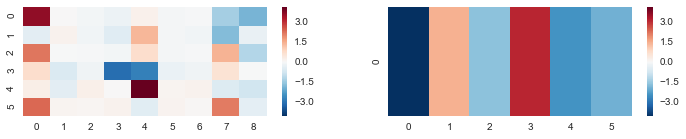

23, 0.90, -2.9513091462, -2.4458842362


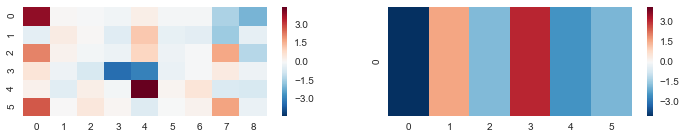

23, 0.80, -2.8983536945, -2.9661611651


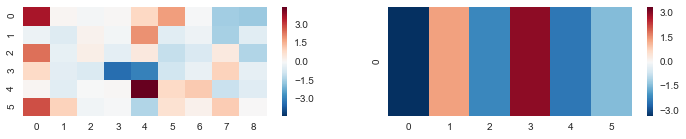

23, 0.70, -3.1064644661, -0.9604081312


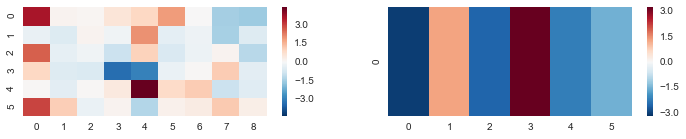

23, 0.60, -2.3041632525, -2.5679463650


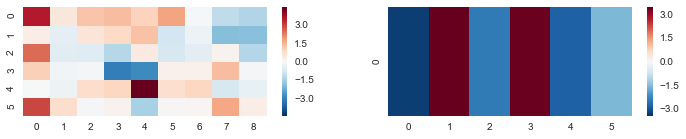

23, 0.50, -2.4382638396, -1.1909440941


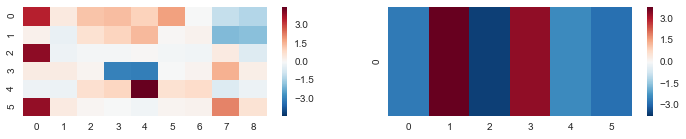

23, 0.40, -0.7835776376, -2.8035728977


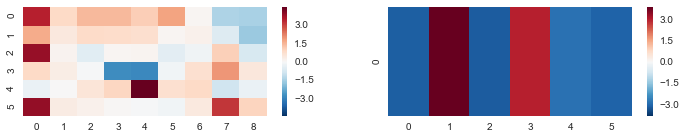

23, 0.30, -1.8049512019, -0.0040000000


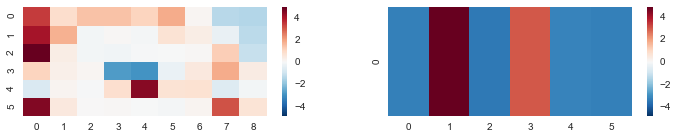

23, 0.20, -0.0027328573, -0.0040000000


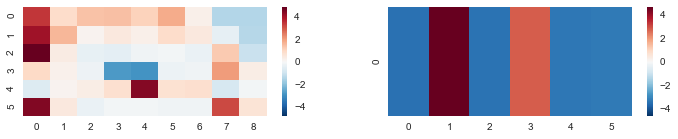

23, 0.10, -0.0016000000, -0.0040000000


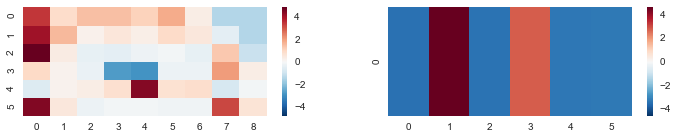

In [35]:
for agent_random_action in tqdm_notebook(np.arange(1, 0, -.1), desc="main"):
    agent.RANDOM_ACTION_P = agent_random_action
    agent.clear_history()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(2000), desc="train", leave=False), visual=False, save=False)

    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    mean_train_revard = y_train.mean()

    y_train = np.pad(y_train, (0, 2 * REWARD_SHIFT), mode="constant")
    norm_reward_size = REWARD_SHIFT * (REWARD_SHIFT - 1) / 2
    reduce(lambda a, b: a + b, [y_train[i:(-2 * REWARD_SHIFT + i)] * i / norm_reward_size for i in range(1, REWARD_SHIFT+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    agent.neural_net.SGD(training_data=train_data,
                         epochs=40,
                         mini_batch_size=MINI_BATCH_SIZE,
                         eta=0.05)

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"{map_seed}, {agent_random_action:.2f}, {mean_train_revard:.10f}, {mean_test_reward:.10f}"
    print(log_message)
    plt.figure(figsize=(12,2))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(agent.neural_net.weights[0])
    plt.subplot(1, 2, 2)
    ax = sns.heatmap(agent.neural_net.weights[1])
    plt.show()

# Смотрим вживую и продолжаем учиться

In [36]:
agent.RANDOM_ACTION_P = 0.00

for map_seed in map_seeds[:1]:
    print("train on map = {}".format(map_seed))

    # Меняем карту
    w = create_map(seed=map_seed, agent=agent)

    # Учимся
    w.run(steps=None, visual=True)

train on map = 23
Saved agent parameters to 'network_config_agent_0_layers_9_6_1.txt'


In [ ]:
# чистим историю: не учимся повторно на старой карте, ускоряемся
agent.clear_history()

# Немного покатаемся для отладки

In [ ]:
for map_seed in map_seeds:
    # Меняем карту
    w = create_map(seed=map_seed, agent=agent)
    
    # оцениваем
    revard = w.evaluate_agent(agent, steps=200, visual=True)
    print("evaluate_agent on map = {}, reward = {}".format(map_seed, revard))